In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import os

from cal_omega_barV import get_bar_v_omega
from general_PD import find_long_instabi, find_short_instabi, find_contours


def get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr_A, Dr_B, bar_rho_A, bar_rho_B, bar_vA=1, bar_vB=1, kappa=0.7,
                            extent=[0, 4, 0, 4], qmin=1e-5, qmax=1, Nq=200, resolution=1000, overwrite=False, ll=3./20, simple_gamma=False):
    if simple_gamma:
        folder = "data/PD_pA_pB_SG/"
    elif ll == 0.:
        folder = "data/PD_pA_pB_woS/"
    else:
        folder = "data/PD_pA_pB/"
    fout = "%se%g_%g_%g_%g_D%g_%g_r%g_%g_qm%g_r%g.npz" % (
        folder, etaAA, etaAB, etaBA, etaBB, Dr_A, Dr_B, bar_rho_A, bar_rho_B, qmax, resolution
    )
    if not overwrite and os.path.exists(fout):
        with np.load(fout, "rb") as data:
            return data["extent"], data["state"], data["q_range"]
    else:
        nrows, ncols = resolution, resolution
        pA = np.linspace(extent[0], extent[1], ncols)
        pB = np.linspace(extent[2], extent[3], nrows)
        pA_2D, pB_2D = np.meshgrid(pA, pB)
        vA_0, vB_0, wAA, wAB, wBA, wBB = get_bar_v_omega(
            etaAA, etaAB, etaBA, etaBB, pA_2D, pB_2D, bar_rho_A, bar_rho_B, bar_vA, bar_vB, kappa)
        w1 = 1 + wAA
        w2 = 1 + wBB
        wc = wAB * wBA
        sigma_D = Dr_A / Dr_B
        sigma_v = vA_0 / vB_0
        Pe = vB_0 / Dr_B

        mask_LS, mask_LOI, mask_LSI = find_long_instabi(sigma_D, sigma_v, Pe, w1, w2, wc, q0=qmin, ll=ll, simple_gamma=simple_gamma)
        q0_a4, q0_Delta3 = np.zeros((2, nrows, ncols))
        for row in range(nrows):
            for col in range(ncols):
                if mask_LS[row, col]:
                    q0_a4[row, col], q0_Delta3[row, col] = find_short_instabi(
                        sigma_D, sigma_v[row, col], Pe[row, col], w1[row, col], w2[row, col], wc[row, col], qmin=qmin, qmax=qmax, Nq=Nq, ll=ll, simple_gamma=simple_gamma)
        state = np.zeros((nrows, ncols), dtype=np.byte)
        state[mask_LSI] = 1
        state[mask_LOI] = 2
        state[q0_a4 > 0] = 3
        state[q0_Delta3 > 0] = 4
        q_range = np.array([qmin, qmax, Nq])
        np.savez_compressed(fout, extent=extent, state=state, q_range=q_range)
        return extent, state, q_range


def plot_PD_composition(state, extent, xlim=None, ylim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
        flag_show = True
    else:
        flag_show = False
    nrows, ncols = state.shape
    contours = find_contours(state)
    for contour in contours["LWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        # ax.plot(x, y, c="tab:blue", lw=1)
        ax.fill(x, y, c="tab:blue", alpha=0.5)

    for contour in contours["LWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        # ax.plot(x, y, c="tab:pink", lw=1)
        ax.fill(x, y, c="tab:pink", alpha=0.5)
    
    for contour in contours["SWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        ax.fill(x, y, c="tab:orange", alpha=0.5)


    for contour in contours["SWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        ax.fill(x, y, c="tab:green", alpha=0.5)

    if xlim is None:
        xlim = [extent[0], extent[1]]
    if ylim is None:
        ylim = [extent[2], extent[3]]
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    if flag_show:
        plt.show()
        plt.close()


# Dr = 0.1
# etaAA = etaBB = -0.25
# etaAB = 1
# etaBA = -etaAB
# # plot_PD_composition(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
# extent = [0, 6, 0, 6]
# extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=1000, extent=extent)
# plot_PD_composition(state, extent, xlim=[0, 6], ylim=[0, 6])
# extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000, ll=0.)
# plot_PD_composition(state, extent, xlim=[0, 3], ylim=[0, 3])

# extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2, Nq=400, resolution=4000)
# plot_PD_composition(state, extent, xlim=[0, 3], ylim=[0, 3])

# Dr = 0.1
# etaAA = etaBB = 0
# etaAB = 1
# etaBA = -etaAB
# # plot_PD_composition(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
# extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
# plot_PD_composition(state, extent, xlim=[0, 3], ylim=[0, 3])

0.47 0.15513968986287305
0.5 0.24133730616429566
0.48 0.18387222863001393
0.475 0.1695059592464435


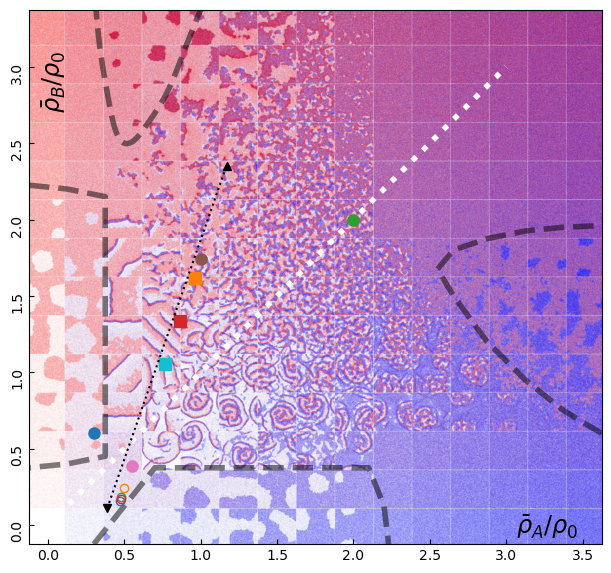

In [5]:
def load_composition_plane(ax=None, label_font_size="xx-large"):
    from scipy.interpolate import CubicSpline
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
        flag_show = True
    else:
        flag_show = False
    image = mpimg.imread("fig/L40_40_Dr0.1_r20_e-2_J0.50_reduced.jpeg")
    extent = [-0.125, 3.625, -0.125, 3.625]
    ax.imshow(image, extent=extent)
    ax.text(0.85, 0.02, r"$\bar{\rho}_A/\rho_0$", fontsize=label_font_size, transform=ax.transAxes)
    ax.text(0.02, 0.82, r"$\bar{\rho}_B/\rho_0$", fontsize=label_font_size, rotation=90, transform=ax.transAxes)

    x_u =np.array([0.3, 0.315, 0.34, 0.38, 0.43, 0.5, 0.65, 0.8, 0.9, 1, 1.1])
    y_u =np.array([3.625, 3.375, 3.125, 2.875, 2.625, 2.5, 2.625, 2.875, 3.125, 3.375, 3.625])
    # ax.plot(x_u, y_u, "o")
    
    cs = CubicSpline(x_u, y_u)
    xs = np.linspace(x_u[0], x_u[-1], 100)
    ys = cs(xs)

    ax.plot(xs, ys, "--", lw=4, c="k", alpha=0.5)
    
    x_l = np.array([-0.125, 0.125, 0.375, 0.375, 0.375, 0.375, 0.375, 0.375, 0.125, -0.125])
    y_l = np.array([2.225, 2.2, 2.15, 1.875, 1.655, 1.0, 0.75, 0.45, 0.4, 0.375])

    ax.plot(x_l, y_l, "--", lw=4, c="k", alpha=0.5)
    # cs = CubicSpline(y_l[::-1], x_l[::-1])
    # ys = np.linspace(y_l[-1], y_l[0], 100)
    # xs = cs(ys)

    x_d = np.array([0.3, 0.5, 0.7, 2.1, 2.2, 2.23])
    y_d = np.array([-0.125, 0.125, 0.375, 0.375, 0.125, -0.125])
    ax.plot(x_d, y_d, "--", lw=4, c="k", alpha=0.5)

    ax.plot([0, 3], [0, 3], c="w", linestyle="dotted", lw=4)

    x_r = np.array([3.625, 3.375, 3.125, 2.875, 2.655, 2.55, 2.655, 2.875, 3.125, 3.375, 3.625])
    y_r = np.array([0.6, 0.75, 0.95, 1.2, 1.5, 1.675, 1.8, 1.875, 1.925, 1.95, 1.96])
    # ax.plot(x_r, y_r, "o", c="tab:red")
    ax.plot(x_r, y_r, "--", lw=4, c="k", alpha=0.5)
    # ax.set_yticklabels(ax.get_yticks(), rotation=90)
    for tick in ax.get_yticklabels():
        tick.set_rotation(90)
    ax.plot(0.3, 0.6, "o", c="tab:blue", ms=8)
    ax.plot(0.55, 0.385, "o", c="tab:pink", ms=8)
    ax.plot(2, 2, "o", c="tab:green", ms=8)

    ax.set_ylim(ymax=3.375)
    pA1 = [7.6525/10, 8.625/10, 9.597/10]
    pB1 = [10.5675/10, 13.36/10, 16.152/10]
    c = ["tab:cyan", "tab:red", "tab:orange"]
    for j in range(3):
        ax.plot(pA1[j], pB1[j], "s", ms=8, c=c[j])

    ax.plot(1, 8.7 * 2/10, "o", c="tab:brown", ms=8)

    gas_binodals = [0.3886, 0.111]
    liquid_binodals = [1.1689, 2.353]
    rhoA_b = [gas_binodals[0], liquid_binodals[0]]
    rhoB_b = [gas_binodals[1], liquid_binodals[1]]
    ax.plot(gas_binodals[0], gas_binodals[1], "v", c="k")
    ax.plot(liquid_binodals[0], liquid_binodals[1], "^", c="k")
    ax.plot(rhoA_b, rhoB_b, "k:")

    k = (rhoB_b[1] - rhoB_b[0]) / (rhoA_b[1] - rhoA_b[0])
    x = 0.47
    y = (x-0.55) * k + 0.385
    ax.plot(x, y, "o", fillstyle="none")
    print(x, y)

    x = 0.5
    y = (x-0.55) * k + 0.385
    ax.plot(x, y, "o", fillstyle="none")
    print(x, y)

    x = 0.48
    y = (x-0.55) * k + 0.385
    ax.plot(x, y, "o", fillstyle="none")
    print(x, y)

    x = 0.475
    y = (x-0.55) * k + 0.385
    ax.plot(x, y, "o", fillstyle="none")
    print(x, y)

    if flag_show:
        plt.show()
        plt.close()
    # plt.savefig("fig/PD_composition_plane.pdf", dpi=200)
    # plt.close()


load_composition_plane()

0.47 0.15513968986287305
0.5 0.24133730616429566
0.48 0.18387222863001393
0.49 0.21260476739715478


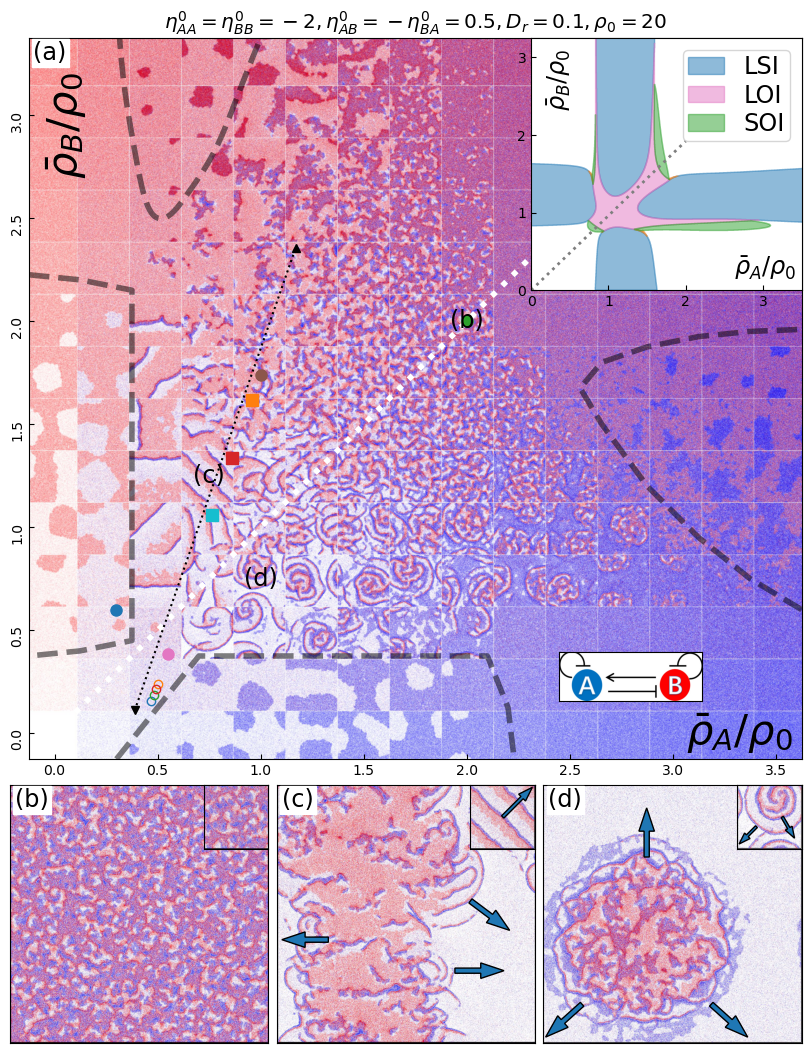

In [4]:
# FIG2: (a) phase diagram on (phiA, phiB) with eta=-2, eta_AB=0.5, L=40.
# (b,c,d) Typical snapshots with L=160
import matplotlib.patches as mpatches

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

fig = plt.figure(constrained_layout=True, figsize=(8, 10.4))
# fig = plt.figure(figsize=(8, 5.9))

subfigs = fig.subfigures(2, 1, wspace=0.0001, hspace=0.0001, height_ratios=[3, 1.05])

ax1 = subfigs[0].subplots(1, 1, gridspec_kw=dict(hspace=0, wspace=0, left=0, right=1, bottom=0, top=1))
(ax2, ax3, ax4) = subfigs[1].subplots(1, 3, gridspec_kw=dict(hspace=0, wspace=0, left=0, right=1, bottom=0, top=1))

### ax1
ax1_in = ax1.inset_axes([0.65, 0.65, 0.35, 0.35])
Dr = 0.1
etaAA = etaBB = -2
etaAB = 0.5
etaBA = -etaAB
extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
plot_PD_composition(state, extent, xlim=[0, 3.5], ylim=[0, 3.25], ax=ax1_in)
ax1_in.set_yticks([0, 1, 2, 3])
# image = mpimg.imread("fig/L40_40_Dr0.1_r20_e-2_J0.50_reduced.jpeg")
# extent = [-0.125, 3.625, -0.125, 3.625]
# ax1.imshow(image, extent=extent)
# ax1.set_xlabel(r"$\phi_A/\rho_0$", fontsize="large")
# ax1.set_ylabel(r"$\phi_B/\rho_0$", fontsize="large")
load_composition_plane(ax1, label_font_size=30)

# import matplotlib.lines as mlines
# blue_circle = mlines.Line2D([], [], color="blue", marker="o", markersize=2, label="A", lw=0)
# red_circle = mlines.Line2D([], [], color="red", marker="o", markersize=2, label="B", lw=0)
# ax1.legend(handles=[blue_circle, red_circle], loc=(0.7, 0.05), fontsize="x-large")

width, height = 0.75/3.8, 0.26/3.8
ax_in = ax1.inset_axes([0.68, 0.08, width, height])
ax_in.set_aspect("equal")
ax_in.set_xticks([])
ax_in.set_yticks([])
im = mpimg.imread("/home/yduan/Desktop/NRQS1_Fig/fig1/c2.jpg")
ax_in.imshow(im)
ax_in.set_ylim(477, 0)

# ax1.plot(3.8935/10, 1.2001/10, "v", fillstyle="none", c="tab:grey", ms=9, mew=3)
# ax1.plot(11.0367/10, 21.6776/10, "^", fillstyle="none", c="tab:green", ms=9, mew=3)
# ax1.plot(3.7562/10, 1.111/10, "v", fillstyle="none", c="tab:grey", ms=9, mew=3)
# ax1.plot(11.0441/10, 23.3980/10, "^", fillstyle="none", c="tab:green", ms=9, mew=3)
patches = [mpatches.Patch(color='tab:blue', label='LSI', alpha=0.5),
           mpatches.Patch(color='tab:pink', label='LOI',alpha=0.5),
           mpatches.Patch(color='tab:green', label='SOI', alpha=0.5),
        ]
ax1_in.legend(handles=patches, loc="upper right", fontsize="xx-large", borderpad=0.2, labelspacing=0.2, handlelength=1.5)
ax1_in.text(0.75, 0.06, r"$\bar{\rho}_A/\rho_0$", fontsize="xx-large", transform=ax1_in.transAxes)
ax1_in.text(0.05, 0.74, r"$\bar{\rho}_B/\rho_0$", fontsize="xx-large", rotation=90, transform=ax1_in.transAxes)
ax1_in.plot([0, 2], [0, 1.92], c="tab:grey", linestyle="dotted", lw=2)

ax1.set_title(r"$\eta_{AA}^0=\eta_{BB}^0=-2,\eta_{AB}^0=-\eta_{BA}^0=0.5, D_r=0.1, \rho_0=20$", fontsize="x-large")
### ax4
image = mpimg.imread("fig/L160_p20_15_r20_e-2_J05.jpg")
ax4.imshow(image)
ax4.set_xticks([])
ax4.set_yticks([])
ax_in = ax4.inset_axes([0.75, 0.75, 0.25, 0.25])
image = mpimg.imread("fig/L40_p20_15_r20_e-2_J05.jpg")
ax_in.imshow(image)
ax_in.set_xticks([])
ax_in.set_yticks([])
ax4.arrow(0.4, 0.72, 0, 0.1, transform=ax4.transAxes, width=0.02, color="tab:blue", ec="k")
ax4.arrow(0.15, 0.15, 0.1 * np.cos(-np.pi * 2.3/3), 0.1 * np.sin(-np.pi * 2.3/3), transform=ax4.transAxes, width=0.02, color="tab:blue", ec="k")
ax4.arrow(0.65, 0.15, 0.1 * np.cos(-np.pi * 0.7/3), 0.1 * np.sin(-np.pi * 0.7/3), transform=ax4.transAxes, width=0.02, color="tab:blue", ec="k")
ax_in.arrow(0.3, 0.35, 0.2 * np.cos(-np.pi * 0.75), 0.2 * np.sin(-np.pi * 0.75), transform=ax_in.transAxes, width=0.04, color="tab:blue", ec="k")
ax_in.arrow(0.7, 0.5, 0.2 * np.cos(-np.pi * 1/3), 0.2 * np.sin(-np.pi * 1/3), transform=ax_in.transAxes, width=0.04, color="tab:blue", ec="k")



### ax3
image = mpimg.imread("fig/L160_p15_25_r20_e-2_J05.jpg")
ax3.imshow(image)
ax3.set_xticks([])
ax3.set_yticks([])
ax_in = ax3.inset_axes([0.75, 0.75, 0.25, 0.25])
image = mpimg.imread("fig/L40_p15_25_r20_e-2_J05.jpg")
ax_in.imshow(image)
ax_in.set_xticks([])
ax_in.set_yticks([])
ax3.arrow(0.75, 0.55, 0.08, -0.06, transform=ax3.transAxes, width=0.02, color="tab:blue", ec="k")
ax3.arrow(0.69, 0.28, 0.1, 0, transform=ax3.transAxes, width=0.02, color="tab:blue", ec="k")
ax3.arrow(0.2, 0.4, -0.09, 0, transform=ax3.transAxes, width=0.02, color="tab:blue", ec="k")
ax_in.arrow(0.5, 0.5, 0.3, 0.3, transform=ax_in.transAxes, width=0.05, color="tab:blue", ec="k")

### ax2
image = mpimg.imread("fig/L160_p40_40_r20_e-2_J05.jpg")
ax2.imshow(image)
ax2.set_xticks([])
ax2.set_yticks([])
ax_in = ax2.inset_axes([0.75, 0.75, 0.25, 0.25])
image = mpimg.imread("fig/L40_p40_40_r20_e-2_J05.jpg")
ax_in.imshow(image)
ax_in.set_xticks([])
ax_in.set_yticks([])

bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.08")
ax1.text(0.006, 0.969, "(a)", fontsize="xx-large", transform=ax1.transAxes, bbox=bbox)
ax2.text(0.02, 0.915, "(b)", fontsize="xx-large", transform=ax2.transAxes, bbox=bbox)
ax3.text(0.02, 0.915, "(c)", fontsize="xx-large", transform=ax3.transAxes, bbox=bbox)
ax4.text(0.02, 0.915, "(d)", fontsize="xx-large", transform=ax4.transAxes, bbox=bbox)

# ax2_in = ax2.inset_axes([0.42, 0.92, 0.08, 0.08])
# ax4_in0.set_xticks([])
# ax4_in0.set_yticks([])
# ax4_in0.scatter(0.4, 0.5, s=60, c="tab:blue", marker="o", edgecolors="k")
# ax1.scatter(2, 2, s=65, c="tab:green", marker="o", edgecolors="k")
# ax1.scatter(15/20, 25/20, s=70, c="tab:pink", marker="s", edgecolors="k")
# ax1.scatter(20/20, 15/20, s=70, c="tab:pink", marker="p", edgecolors="k")

# bbox=dict(edgecolor="w", facecolor="w", boxstyle="Square, pad=0.08")
ax1.text(2, 2, "(b)", fontsize="xx-large", c="k", ha="center", va="center")
ax1.text(15/20, 25/20, "(c)", fontsize="xx-large", c="k", ha="center", va="center")
ax1.text(20/20, 15/20, "(d)", fontsize="xx-large", c="k", ha="center", va="center")

# plt.savefig("fig/f2_v5.pdf", dpi=200)
plt.show()
plt.close()
